# Task 2.3: Transcriptome Analysis
## Differential Expression Analysis of APOE4 vs APOE4→E2 Switch

**Dataset:** GSE300079 - Single-cell RNA-seq from mouse brain
**Goal:** Identify differentially expressed genes between APOE4 controls and APOE4→E2 switched mice

### Sample Groups (from series_matrix.txt):
- **Control (APOE4):** GSM9053416_S9 (no Cre), GSM9053419_S12 (E4-TR)
- **Switched (E4→E2):** GSM9053410_S1, GSM9053411_S2, GSM9053412_S3 (Global Cre)

### Approach: Pseudo-bulking
Since this is single-cell data but we need a simple DEG list, we'll:
1. Load each sample's single-cell matrix
2. Sum counts across all cells per sample (pseudo-bulk)
3. Normalize to CPM and log-transform
4. Perform t-test for differential expression
5. Generate volcano plot and gene lists


In [12]:
# Cell 1: Imports and Setup
import os
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import false_discovery_control
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = "../Data/GSE300079_RAW"
OUTPUT_DIR = "../Data"

In [13]:
# Cell 2: Define Sample Groups based on metadata
# From GSE300079_series_matrix.txt:
# - GSM9053410_S1: "4s2 Global Cre, rep1" -> SWITCHED (genotype: 4S2/4S2, GC/+)
# - GSM9053411_S2: "4s2 Global Cre, rep2" -> SWITCHED
# - GSM9053412_S3: "4s2 Global Cre, rep3" -> SWITCHED
# - GSM9053416_S9: "4s2 no Cre"           -> CONTROL (no switch, stays APOE4)
# - GSM9053419_S12: "E4-TR"               -> CONTROL (constitutive E4/E4)

# Control group: mice expressing APOE4
control_samples = ['GSM9053416_S9', 'GSM9053419_S12']

# Treatment group: mice switched from APOE4 to APOE2 (Global Cre)
switched_samples = ['GSM9053410_S1', 'GSM9053411_S2', 'GSM9053412_S3']

# Create metadata dataframe
metadata = pd.DataFrame({
    'sample': control_samples + switched_samples,
    'group': ['Control']*len(control_samples) + ['Switched']*len(switched_samples),
    'description': ['4s2 no Cre (stays E4)', 'E4-TR (constitutive E4)',
                    'Global Cre rep1 (E4→E2)', 'Global Cre rep2 (E4→E2)', 'Global Cre rep3 (E4→E2)']
})
print("Sample Metadata:")
print(metadata.to_string(index=False))


Sample Metadata:
        sample    group             description
 GSM9053416_S9  Control   4s2 no Cre (stays E4)
GSM9053419_S12  Control E4-TR (constitutive E4)
 GSM9053410_S1 Switched Global Cre rep1 (E4→E2)
 GSM9053411_S2 Switched Global Cre rep2 (E4→E2)
 GSM9053412_S3 Switched Global Cre rep3 (E4→E2)


In [14]:
# sum all cell counts per sample to create bulk profiles

all_samples = control_samples + switched_samples
bulk_data = {}

for sample in all_samples:
    sample_path = os.path.join(DATA_DIR, sample)
    print(f"  Processing {sample}...")
    
    try:
        # Load 10x Genomics matrix (barcodes.tsv.gz, features.tsv.gz, matrix.mtx.gz)
        adata = sc.read_10x_mtx(sample_path, var_names='gene_symbols', cache=True)
        
        # sum counts across all cells -> one profile per sample
        sample_sum = np.array(adata.X.sum(axis=0)).flatten()
        bulk_data[sample] = pd.Series(sample_sum, index=adata.var_names)
        
        print(f"    Loaded {adata.n_obs} cells, {adata.n_vars} genes")
    except Exception as e:
        print(f"    ERROR: {e}")

# Create DataFrame (rows=genes, cols=samples)
counts_df = pd.DataFrame(bulk_data)
print(f"\nmatrix shape: {counts_df.shape[0]} genes x {counts_df.shape[1]} samples")


  Processing GSM9053416_S9...
    Loaded 8355 cells, 32285 genes
  Processing GSM9053419_S12...
    Loaded 27027 cells, 32285 genes
  Processing GSM9053410_S1...
    Loaded 13988 cells, 32285 genes
  Processing GSM9053411_S2...
    Loaded 19755 cells, 32285 genes
  Processing GSM9053412_S3...
    Loaded 29793 cells, 32285 genes

matrix shape: 32285 genes x 5 samples


In [15]:
# Normalize data (CPM + log2 transformation)

# Fill NaN with 0 and ensure numeric
counts_df = counts_df.fillna(0)

# CPM normalization (Counts Per Million)
cpm = counts_df.div(counts_df.sum(axis=0), axis=1) * 1e6

# Log2 transformation: log2(CPM + 1)
log_cpm = np.log2(cpm + 1)

# Filter lowly expressed genes (mean CPM > 1 across samples)
expressed = cpm.mean(axis=1) > 1
log_cpm_filtered = log_cpm[expressed]

print(f"Genes after filtering: {log_cpm_filtered.shape[0]} (from {log_cpm.shape[0]})")
print(f"\nLog2(CPM+1) matrix preview:")
log_cpm_filtered.head()


Genes after filtering: 14945 (from 32285)

Log2(CPM+1) matrix preview:


,GSM9053416_S9,GSM9053419_S12,GSM9053410_S1,GSM9053411_S2,GSM9053412_S3
Xkr4,2.292197,1.902899,2.456789,2.158628,2.221045
Gm19938,2.005799,2.178796,2.544243,2.176084,2.532615
Rp1,1.664247,1.100738,0.933512,0.881623,0.730165
Sox17,5.086750,5.130507,5.523212,4.727419,4.808969
Mrpl15,5.889810,5.909726,5.896346,5.950934,5.701275


In [16]:
# Differential Expression Analysis (T-test)
# Compare Control (APOE4) vs Switched (E4→E2)

# Get valid sample columns
valid_controls = [s for s in control_samples if s in log_cpm_filtered.columns]
valid_switched = [s for s in switched_samples if s in log_cpm_filtered.columns]

print(f"Control samples: {valid_controls}")
print(f"Switched samples: {valid_switched}")

results = []
for gene in log_cpm_filtered.index:
    ctrl_vals = log_cpm_filtered.loc[gene, valid_controls].values
    switch_vals = log_cpm_filtered.loc[gene, valid_switched].values
    
    # Log2 Fold Change: Switched - Control (in log2 space)
    log2fc = switch_vals.mean() - ctrl_vals.mean()
    
    # T-test (Welch's t-test for unequal variances)
    t_stat, p_val = stats.ttest_ind(switch_vals, ctrl_vals, equal_var=False)
    
    results.append({
        'Gene': gene,
        'Log2FC': log2fc,
        'P_Value': p_val,
        'Mean_Control': ctrl_vals.mean(),
        'Mean_Switched': switch_vals.mean()
    })

results_df = pd.DataFrame(results)

# Handle NaN p-values (from constant expression)
results_df['P_Value'] = results_df['P_Value'].fillna(1.0)

print(f"\nDifferential expression analysis complete: {len(results_df)} genes tested")


Control samples: ['GSM9053416_S9', 'GSM9053419_S12']
Switched samples: ['GSM9053410_S1', 'GSM9053411_S2', 'GSM9053412_S3']

Differential expression analysis complete: 14945 genes tested


In [17]:
# Multiple Testing Correction and Significance Filtering

# -Log10(P-value) for volcano plot
results_df['-Log10P'] = -np.log10(results_df['P_Value'].clip(lower=1e-300))

# FDR correction (Benjamini-Hochberg)
results_df['FDR'] = false_discovery_control(results_df['P_Value'], method='bh')

# Define significance thresholds
P_THRESHOLD = 0.05
FC_THRESHOLD = 0.5  # Log2FC threshold (1.41-fold change)

# Mark significant genes
results_df['Significant'] = (
    (results_df['P_Value'] < P_THRESHOLD) & 
    (abs(results_df['Log2FC']) > FC_THRESHOLD)
)

# Count significant genes
n_sig = results_df['Significant'].sum()
n_up = ((results_df['Significant']) & (results_df['Log2FC'] > 0)).sum()
n_down = ((results_df['Significant']) & (results_df['Log2FC'] < 0)).sum()

print(f"Significant DEGs (p<{P_THRESHOLD}, |Log2FC|>{FC_THRESHOLD}): {n_sig}")
print(f"  - Upregulated in Switched: {n_up}")
print(f"  - Downregulated in Switched: {n_down}")


Significant DEGs (p<0.05, |Log2FC|>0.5): 63
  - Upregulated in Switched: 4
  - Downregulated in Switched: 59


Volcano plot saved to ../Data/volcano_plot.png


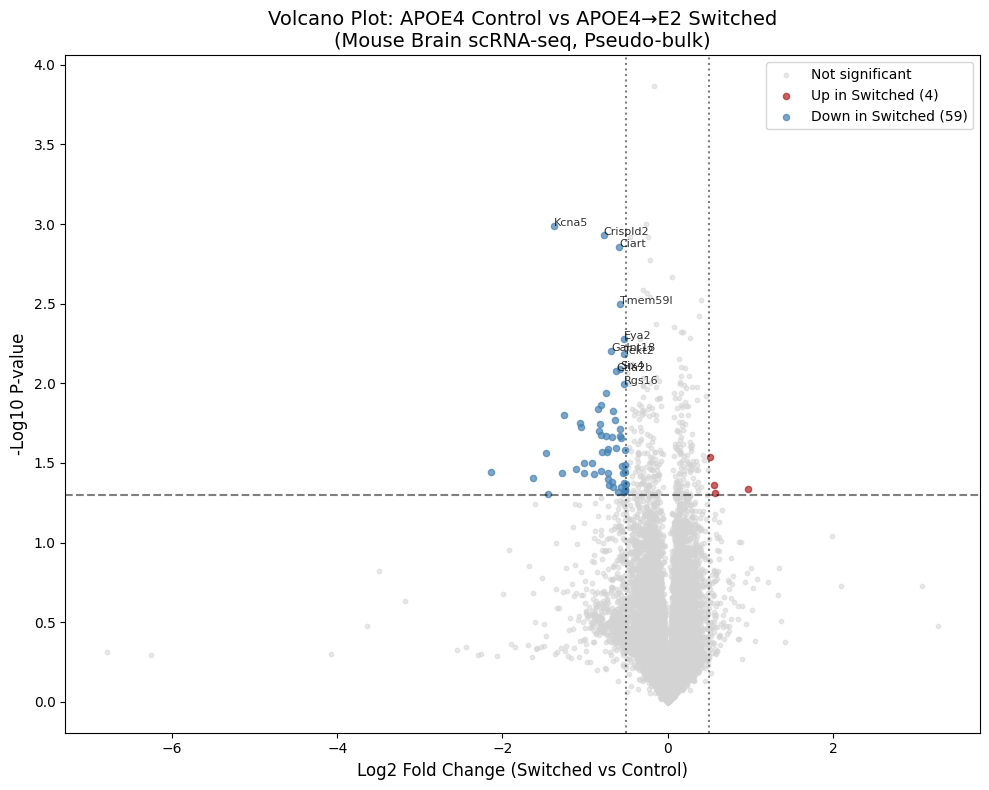

In [18]:
# Volcano Plot

fig, ax = plt.subplots(figsize=(10, 8))

# Non-significant genes (grey)
non_sig = results_df[~results_df['Significant']]
ax.scatter(non_sig['Log2FC'], non_sig['-Log10P'], 
           c='lightgrey', alpha=0.5, s=10, label='Not significant')

# Upregulated (red)
up = results_df[(results_df['Significant']) & (results_df['Log2FC'] > 0)]
ax.scatter(up['Log2FC'], up['-Log10P'], 
           c='firebrick', alpha=0.7, s=20, label=f'Up in Switched ({len(up)})')

# Downregulated (blue)
down = results_df[(results_df['Significant']) & (results_df['Log2FC'] < 0)]
ax.scatter(down['Log2FC'], down['-Log10P'], 
           c='steelblue', alpha=0.7, s=20, label=f'Down in Switched ({len(down)})')

# Threshold lines
ax.axhline(-np.log10(P_THRESHOLD), color='black', linestyle='--', alpha=0.5)
ax.axvline(FC_THRESHOLD, color='black', linestyle=':', alpha=0.5)
ax.axvline(-FC_THRESHOLD, color='black', linestyle=':', alpha=0.5)

# Label top 10 genes by significance
top_genes = results_df[results_df['Significant']].nsmallest(10, 'P_Value')
for _, row in top_genes.iterrows():
    ax.annotate(row['Gene'], (row['Log2FC'], row['-Log10P']), 
                fontsize=8, alpha=0.8)

ax.set_xlabel('Log2 Fold Change (Switched vs Control)', fontsize=12)
ax.set_ylabel('-Log10 P-value', fontsize=12)
ax.set_title('Volcano Plot: APOE4 Control vs APOE4→E2 Switched\n(Mouse Brain scRNA-seq, Pseudo-bulk)', fontsize=14)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'volcano_plot.png'), dpi=150)
print(f"Volcano plot saved to {OUTPUT_DIR}/volcano_plot.png")
plt.show()


In [19]:
# Save Results to CSV

# Sort by p-value
results_df_sorted = results_df.sort_values('P_Value')

# Save full results
output_file = os.path.join(OUTPUT_DIR, 'differential_expression_results.csv')
results_df_sorted.to_csv(output_file, index=False)
print(f"Full results saved to: {output_file}")

# Save significant genes only
sig_genes_df = results_df_sorted[results_df_sorted['Significant']]
sig_output = os.path.join(OUTPUT_DIR, 'significant_genes.csv')
sig_genes_df.to_csv(sig_output, index=False)
print(f"Significant genes saved to: {sig_output}")


Full results saved to: ../Data/differential_expression_results.csv
Significant genes saved to: ../Data/significant_genes.csv


In [20]:
# Display Top 30 Significant DEGs

print("=" * 80)
print("TOP 30 DIFFERENTIALLY EXPRESSED GENES (by P-value)")
print("=" * 80)
print(f"{'Gene':<15} {'Log2FC':>10} {'P-value':>12} {'FDR':>12} {'Direction':<12}")
print("-" * 80)

for i, row in sig_genes_df.head(30).iterrows():
    direction = "↑ Up" if row['Log2FC'] > 0 else "↓ Down"
    print(f"{row['Gene']:<15} {row['Log2FC']:>10.3f} {row['P_Value']:>12.2e} {row['FDR']:>12.2e} {direction:<12}")


TOP 30 DIFFERENTIALLY EXPRESSED GENES (by P-value)
Gene                Log2FC      P-value          FDR Direction   
--------------------------------------------------------------------------------
Kcna5               -1.374     1.03e-03     1.00e+00 ↓ Down      
Crispld2            -0.774     1.17e-03     1.00e+00 ↓ Down      
Ciart               -0.586     1.39e-03     1.00e+00 ↓ Down      
Tmem59l             -0.573     3.16e-03     1.00e+00 ↓ Down      
Eya2                -0.528     5.28e-03     1.00e+00 ↓ Down      
Galnt18             -0.681     6.23e-03     1.00e+00 ↓ Down      
Tekt2               -0.532     6.52e-03     1.00e+00 ↓ Down      
Six4                -0.574     8.08e-03     1.00e+00 ↓ Down      
Ctla2b              -0.621     8.32e-03     1.00e+00 ↓ Down      
Rgs16               -0.528     1.01e-02     1.00e+00 ↓ Down      
Ces1d               -0.747     1.15e-02     1.00e+00 ↓ Down      
Minar2              -0.809     1.37e-02     1.00e+00 ↓ Down      
Tnfrsf11b 

In [21]:
# Prepare Gene Lists for Enrichment

# Upregulated genes (higher in Switched/E2)
up_genes = sig_genes_df[sig_genes_df['Log2FC'] > 0]['Gene'].tolist()

# Downregulated genes (lower in Switched/E2)  
down_genes = sig_genes_df[sig_genes_df['Log2FC'] < 0]['Gene'].tolist()

print(f"Upregulated genes ({len(up_genes)}):")
print(", ".join(up_genes[:50]))  # Show first 50
if len(up_genes) > 50:
    print(f"... and {len(up_genes)-50} more")

print(f"\nDownregulated genes ({len(down_genes)}):")
print(", ".join(down_genes[:50]))
if len(down_genes) > 50:
    print(f"... and {len(down_genes)-50} more")

# Save gene lists for external enrichment tools
with open(os.path.join(OUTPUT_DIR, 'upregulated_genes.txt'), 'w') as f:
    f.write('\n'.join(up_genes))
with open(os.path.join(OUTPUT_DIR, 'downregulated_genes.txt'), 'w') as f:
    f.write('\n'.join(down_genes))
    
print(f"\nGene lists saved to {OUTPUT_DIR}/")


Upregulated genes (4):
1500015A07Rik, Ighm, Fbn2, Mir9-3hg

Downregulated genes (59):
Kcna5, Crispld2, Ciart, Tmem59l, Eya2, Galnt18, Tekt2, Six4, Ctla2b, Rgs16, Ces1d, Minar2, Tnfrsf11b, Bex2, Fam183b, Errfi1, Ly6h, Slc26a7, Fibin, A530084C06Rik, Rit2, Cdh26, Pdk4, Lypd2, Gch1, Celf3, Ppl, Cd24a, Mamdc2, Sult1a1, Bag2, E230001N04Rik, Per1, Rasl11a, Ky, Gimap6, A730020M07Rik, Proser2, Eps8l1, Klf5, Ccn3, Tcim, Ccn2, Smim3, Cyp26b1, Scg2, Eppk1, Hist1h4j, Penk, Sdc4
... and 9 more

Gene lists saved to ../Data/


In [22]:
# Cell 11: Summary Statistics

print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)
print(f"Dataset: GSE300079 (APOE4→E2 switch in mouse brain)")
print(f"Method: differential expression (t-test)")
print(f"")
print(f"Samples analyzed:")
print(f"  Control (APOE4): {len(valid_controls)} samples")
print(f"  Switched (E4→E2): {len(valid_switched)} samples")
print(f"")
print(f"Results:")
print(f"  Total genes tested: {len(results_df)}")
print(f"  Significant DEGs: {n_sig}")
print(f"    - Upregulated: {n_up}")
print(f"    - Downregulated: {n_down}")
print(f"")
print(f"Thresholds: p < {P_THRESHOLD}, |Log2FC| > {FC_THRESHOLD}")
print("=" * 60)


ANALYSIS SUMMARY
Dataset: GSE300079 (APOE4→E2 switch in mouse brain)
Method: differential expression (t-test)

Samples analyzed:
  Control (APOE4): 2 samples
  Switched (E4→E2): 3 samples

Results:
  Total genes tested: 14945
  Significant DEGs: 63
    - Upregulated: 4
    - Downregulated: 59

Thresholds: p < 0.05, |Log2FC| > 0.5
